### Import the necessary libraries to use in the repo

In [1]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pylab as pylab
import luminol
from luminol import utils , anomaly_detector
from luminol.anomaly_detector import AnomalyDetector
import tad.anomaly_detect_ts as detts


### We create two functions, set_col_index and sort_time_series to set column index and sort data based on date of data time series respectively

In [2]:
# set index column
class set_col_as_index(TransformerMixin):
    def __init__(self, col):
        self.col = col
    
    def transform (self, X, **transform_params):
        X.index = X.loc[:, self.col].apply(lambda x: pd.to_datetime(x))
        return X
    
    def fit(self, X, y=None, **fit_params):
        return self

### Create index and transform the 'TimeStamp' column

In [3]:
#sort data based on the index
class sort_time_series(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X.sort_index( )
        return X
    
    def fit(self, X, y=None, **fit_params):
        return self
    


### Function to Process dataset

In [4]:
#Create index and transform the 'TimeStamp' column
def process_data(x):
    process_pipeline = make_pipeline(set_col_as_index('time'), sort_time_series())
    x = process_pipeline.fit_transform(x)
    del x['time']
    return x

### Function to load data from csv file, process and return the data

In [5]:
# get test data for water quality monitoring from this directory
def get_temp_data(data_path):
    return pd.read_csv(data_path)


data_path = './node2_data_latest.csv'
df = get_temp_data(data_path)

print('Number of Data samples ', len(df))

df.head()

Number of Data samples  2658


,time,turbidity,pH
0,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
1,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
3,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
4,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


### Display the general information on the dataset loaded

In [6]:
def display_info(df):
    print("Data Range \n")
    print("Start Date %s \n"%(df.head(1)['time']))
    print("End Date %s \n "%(df.tail (1)['time']))
    print("Num_values : %s "%(df.shape[0]))
    
    
display_info(df)

Data Range 

Start Date 0    2020-11-04 11:00:31.822439+00:00
Name: time, dtype: object 

End Date 2657    2021-01-04 09:54:25.214766+00:00
Name: time, dtype: object 
 
Num_values : 2658 


### Plot the Original Dataset

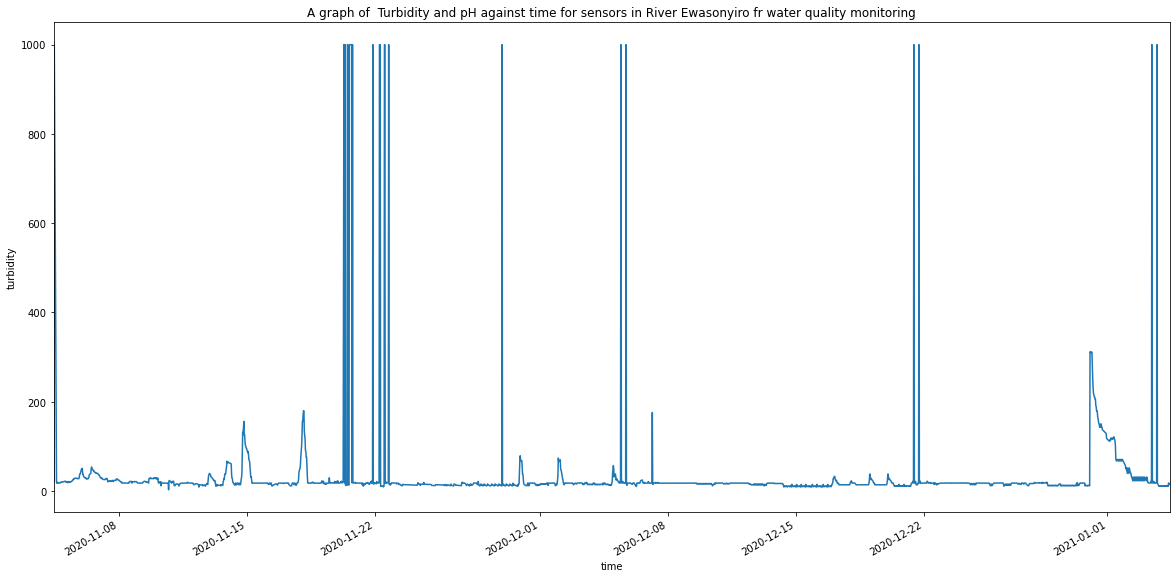

In [14]:
def plot_original_data(df, title):
    f1 = plt.figure(figsize =(20, 10))
    df['turbidity'].plot( )
    plt.xlabel("time")
    plt.ylabel("turbidity")
    plt.title(title)
    plt.show( )
    
    
plot_original_data(df, "A graph of  Turbidity and pH against time for sensors in River Ewasonyiro fr water quality monitoring")

### Prepare traning dataset

In [8]:
def prepare_traning_dataset(df):
    
    #lets get value of dataset
    X = df['turbidity'].values 
    
    # reshape the data to only one column
    X = X.reshape(-1, 1)
    return X

training_data = prepare_traning_dataset(df)

print('Items : ', len(training_data), '\n\n Head')
training_data[:5]

Items :  2658 

 Head


array([[21.06343492],
       [20.8681534 ],
       [20.58455327],
       [21.18532803],
       [21.06343492]])

### Preprocess training dataset 

In [9]:
# lets make the dates as index
df_turbidity = process_data(df)
df.head()

,time,turbidity,pH
time,,,
2020-11-04 11:00:31.822439+00:00,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
2020-11-04 11:01:22.124333+00:00,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2020-11-04 11:01:51.663062+00:00,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
2020-11-04 11:02:29.373718+00:00,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
2020-11-04 11:03:45.517010+00:00,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


In [10]:
df_turbidity = prepare_traning_dataset(df_turbidity)
df.head()

,time,turbidity,pH
time,,,
2020-11-04 11:00:31.822439+00:00,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
2020-11-04 11:01:22.124333+00:00,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2020-11-04 11:01:51.663062+00:00,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
2020-11-04 11:02:29.373718+00:00,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
2020-11-04 11:03:45.517010+00:00,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


### Get prediction result for the turbidity

In [11]:
%%time
clf = LocalOutlierFactor(n_neighbors=800, metric='euclidean')

def lof_prediction(clf, training_data_set, data_set):
    
    #fit clf with training data set
    y_pred = clf.fit_predict(training_data_set)
    
    #Get the prediction score
    y_pred = clf._decision_function(training_data_set)
    
    # combine training data and prediction result
    data_set['isinlier'] = y_pred
    
    #datascores less than -10  are outliers, we get them 
    anomalies = data_set.loc[data_set['isinlier']< -10]
    data_set
    return anomalies

df_turbidity_anomalies = lof_prediction(clf, df_turbidity, df)
df_turbidity_anomalies

Wall time: 1.27 s


,time,turbidity,pH,isinlier
time,,,,
2020-11-04 11:46:47.357143+00:00,2020-11-04 11:46:47.357143+00:00,1000.000000,7.30,-419.570861
2020-11-05 21:03:38.902611+00:00,2020-11-05 21:03:38.902611+00:00,37.734662,7.36,-12.756615
2020-11-05 21:33:54.944352+00:00,2020-11-05 21:33:54.944352+00:00,37.975997,7.35,-12.892603
2020-11-05 22:34:27.035608+00:00,2020-11-05 22:34:27.035608+00:00,42.734662,7.35,-15.376234
2020-11-05 23:04:43.071267+00:00,2020-11-05 23:04:43.071267+00:00,47.734662,7.39,-17.610240
...,...,...,...,...
2021-01-02 05:56:44.850041+00:00,2021-01-02 05:56:44.850041+00:00,43.613165,7.34,-15.656617
2021-01-02 06:57:16.963602+00:00,2021-01-02 06:57:16.963602+00:00,39.491669,7.35,-13.798885
2021-01-02 07:27:33.024504+00:00,2021-01-02 07:27:33.024504+00:00,35.370172,7.35,-11.384495


### Plot the result of LOF anomaly detection

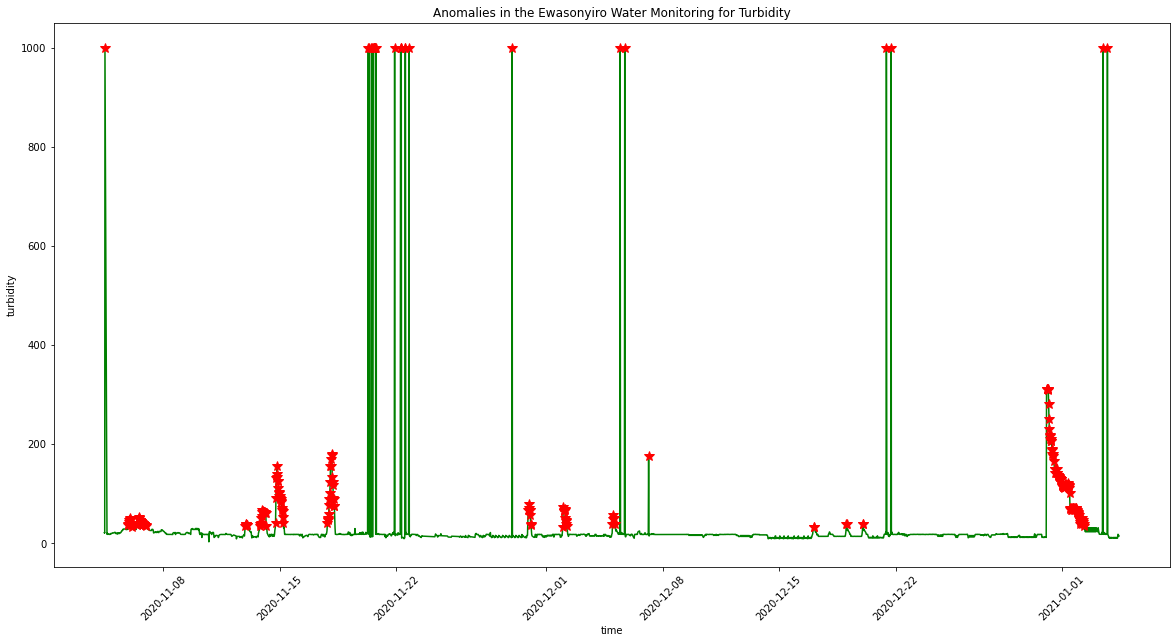

In [16]:
# lets plot the result of LOF anomaly detection
def plot_lof_result(dataset, anomalies, title):
    if 'isinlier' in dataset.columns:
        del dataset['isinlier']
        
    if 'isinlier' in anomalies.columns:
        del anomalies['isinlier']
        
    f2 = plt.figure(figsize =(20, 10))
    plt.plot(dataset['turbidity'], color='green')
    plt.plot(anomalies['turbidity'], "r*", markersize =10)
    plt.xlabel("time")    
    plt.xticks(rotation=45);
    plt.ylabel("turbidity")
    plt.title(title)
    plt.show()
    
    
plot_lof_result(df, df_turbidity_anomalies , "Anomalies in the Ewasonyiro Water Monitoring for Turbidity")


### Save the anomaly detected points as csv file

In [13]:
df_turbidity_anomalies.to_csv('ewasonyiro_turbidity_anomalies.csv')